<a href="https://colab.research.google.com/github/Sreenidhiks8/BlueLearn-Hackathon/blob/master/WQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import files
# Upload the dataset file
uploaded = files.upload()

Saving water_dataX.csv to water_dataX (1).csv


In [ ]:
# Read the file with ISO-8859-1 encoding
df = pd.read_csv("water_dataX.csv", encoding="ISO-8859-1")
df = df.iloc[0:1900, :]
print(df.shape)
df.dtypes

(1900, 12)


STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [ ]:
columns_to_drop = ['STATION CODE', 'LOCATIONS', 'STATE','year','Temp']
df.drop(columns=columns_to_drop, inplace=True)      #original dataset altered

In [ ]:
# Changing column names\
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "Conductivity", "B.O.D. (mg/l)": "BOD", "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

In [ ]:
def convert_to_numeric(df):
    num_col = df.shape[1]                 #shape[1]---no of columns in df
    # Start from index 3 as the first 3 columns doesn't need any numeric conversion
    for index in range( num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
dtype: object

In [ ]:
# Replacing string NAN values with actual NAN value (np.nan)
def convert_to_nan(df):
    n_col = df.shape[1]       #getting no of cols
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

In [ ]:
# Checking for missing values
df.isnull().sum().sort_values()

PH                7
Conductivity     24
DO               30
BOD              42
Tot_col         130
NI              189
Fec_col         280
dtype: int64

In [ ]:
df['Conductivity'] = df['Conductivity'].apply(lambda x: x / 1_000_000)    #to convert the unit from uS/cm to S/m

In [ ]:
df_col = df.columns
imputer = SimpleImputer(strategy="median")      #Imputer= replaces all empty cells with median value

df = imputer.fit_transform(df)
df = pd.DataFrame(df, columns=df_col)

In [ ]:
df.isnull().sum()
df.shape

(1900, 7)

In [ ]:
# Here, almost all kde plots are Gaussian Like
# Using Z-Score Normalization to detect outliers

df_final_norm = zscore(df, axis=0)  #calc z score for each col

def indices_of_greater_than_3(df_norm):       # values with z score +3 or -3 are considered to be outliers
    indices_arr = []                          #empty array to store outliers
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
df.iloc[indices_arr, :]

Number of outliers using Z-Score method- 125


,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col
739,11.1,7.6,0.000131,3.6,0.52,233.0,32.0
743,11.4,7.2,0.000128,1.0,0.52,233.0,20.0
37,5.3,7.7,0.024062,9.9,1.20,156.0,304.0
88,3.7,7.7,0.032005,1.2,0.90,40000.0,60392.0
108,5.6,7.2,0.024360,2.1,0.30,92.0,447.0
...,...,...,...,...,...,...,...
430,3.4,7.8,0.002577,164.9,1.50,148825783.0,160405392.0
683,0.2,7.2,0.002219,185.8,1.75,180000000.0,300000000.0
172,0.9,7.6,0.002039,104.5,0.90,272521616.0,511090873.0
430,3.4,7.8,0.002577,164.9,1.50,148825783.0,160405392.0


In [ ]:
df.drop(indices_arr, axis=0, inplace=True)
df.shape

(1787, 7)

**Calculating** **WQI**

In [ ]:

# Standard values of parameters(si)
si = np.array([10, 8.5, 1000, 5, 45, 100, 1000])
sum_of_si = np.sum(si)

# Ideal values of paramters(vIdeal)
vIdeal = np.array([14.6, 7, 0, 0, 0, 0, 0])

def calc_wqi(sample):
    wqi_sample = 0
    num_col = 7
    sum_of_wi = 0
    K = 1 / sum_of_si

    for index in range(1,num_col):
      v_index = sample[index] # Obeserved value of sample at index
      v_index_ideal = vIdeal[index] # Ideal value of obeserved value
      std_index = si[index] # Standard value recommended for obeserved value
      q_index = 100*(v_index - v_index_ideal) / (std_index - v_index_ideal)
      w_index = K / std_index
      wqi_sample += q_index*w_index
      sum_of_wi += w_index
    return wqi_sample/sum_of_wi

In [ ]:
# Computing WQI for the whole dataset
def calc_wqi_for_df(df):
    wqi_arr = df.apply(calc_wqi,axis=1)
    return wqi_arr

In [ ]:
df['WQI']= calc_wqi_for_df(df)
df_wqi=df

In [ ]:
# These are samples with negative WQI
df_wqi[(df_wqi["WQI"] < 0)]

,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,WQI
127,6.7,6.30,0.000054,0.9000,0.100,136.0,610.0,-1.319404
206,6.7,2.70,0.001350,3.3000,1.100,7.0,16.0,-57.974851
213,7.3,5.60,0.000056,1.8000,2.100,16.0,34.0,-9.984641
245,6.7,0.00,0.000208,1.8965,0.520,233.0,465.0,-127.643373
248,6.7,0.00,0.000506,1.8965,6.000,26.0,227.0,-132.824793
385,6.0,6.10,0.000056,1.2000,0.000,136.0,438.0,-2.429946
463,5.2,2.90,0.000682,7.8000,1.500,16.0,30.0,-2.045614
470,6.8,2.70,0.001074,3.2000,2.330,4.0,11.0,-59.025694
477,7.5,5.70,0.000050,1.5000,2.210,10.0,23.0,-11.324213
638,6.5,6.30,0.000049,1.0000,0.220,87.0,323.0,-1.639904


In [ ]:
# Removing the samples with negative WQI
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

In [ ]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: (3 if (x <= 25)
                                        else(2 if (26<=x<=50)
                                        else(1 if (51<=x<=75)
                                        else 0))))

In [ ]:
df_wqi

,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,WQI,WQI clf
0,6.7,7.50,0.000203,1.8965,0.100,11.0,27.0,33.038425,2
1,5.7,7.20,0.000189,2.0000,0.200,4953.0,8391.0,170.368962,0
2,6.3,6.90,0.000179,1.7000,0.100,3243.0,5330.0,110.790076,0
3,5.8,6.90,0.000064,3.8000,0.500,5382.0,8443.0,196.393040,0
4,5.8,7.30,0.000083,1.9000,0.400,3428.0,5500.0,127.327666,0
...,...,...,...,...,...,...,...,...,...
1895,7.4,7.00,0.000088,0.9770,0.186,27.0,105.0,11.929672,3
1896,6.6,7.81,0.000603,2.6750,0.263,40.0,191.0,49.691831,2
1897,6.6,7.49,0.000571,2.0910,0.256,151.0,273.0,39.097131,2
1898,5.4,7.16,0.000076,2.0920,0.520,404.0,513.0,39.048254,2


In [ ]:
df_wqi.describe()

,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,WQI,WQI clf
count,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000
mean,6.425304,7.269009,0.001024,4.014878,1.127297,2320.217598,7418.944124,119.843162,1.606567
std,1.268272,0.498459,0.002794,7.205280,1.641432,8355.995951,40721.629486,285.993592,1.151439
min,0.000000,3.300000,0.000011,0.100000,0.000000,0.000000,0.000000,0.455307,0.000000
25%,6.000000,6.900000,0.000085,1.191000,0.268750,50.750000,108.750000,23.255252,0.000000
50%,6.700000,7.300000,0.000188,1.855000,0.520000,233.000000,465.000000,40.325938,2.000000
75%,7.154250,7.600000,0.000495,3.400000,1.100000,712.000000,1728.500000,71.683873,3.000000
max,10.000000,9.010000,0.018569,88.000000,13.200000,150250.000000,967500.000000,4459.402424,3.000000


In [ ]:
df_wqi.shape

(1736, 9)

In [ ]:
#To find the number of instances in each class
y = df_wqi['WQI clf']  # Target variable
print("Class distribution:")
print(y.value_counts())

Class distribution:
WQI clf
2    499
3    499
0    444
1    294
Name: count, dtype: int64


In [ ]:
X = df_wqi.drop(columns=['WQI clf'])
y = df_wqi['WQI clf']
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote=SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Display the class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

df_resampled = pd.DataFrame(X_resampled)
df_resampled['WQI clf'] = y_resampled



Class distribution after SMOTE:
WQI clf
1    397
3    397
2    397
0    397
Name: count, dtype: int64


**SVM**

Accuracy: 0.7972350230414746
Precision: 0.8251826740820148
Recall: 0.7972350230414746
F1 Score: 0.7982144640590377


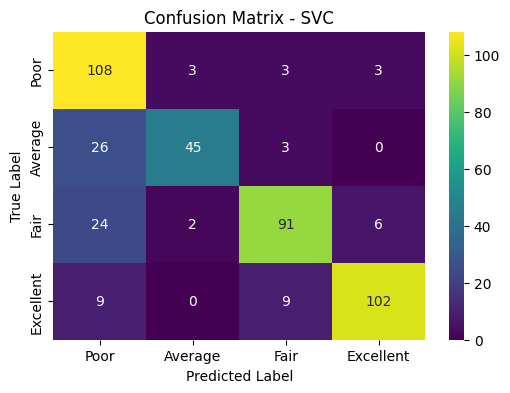

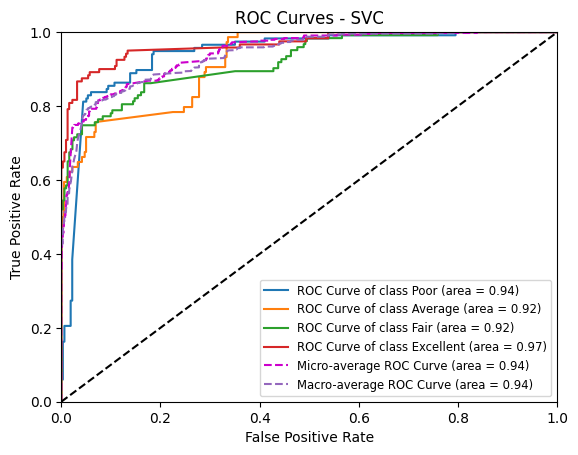

In [ ]:
#SVM MODEL
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
import sklearn.metrics as metrics


X = df_wqi.drop(columns=['WQI clf'])
y=np.ravel(df_wqi[['WQI clf']])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=None)

# Initialize SVM model
svm_model = SVC(kernel='rbf',probability=True)

# Grid search for hyperparameter tuning
param_grid = {'C': [0.01,0.1,1,10,100], 'gamma': [0.1,0.01,0.001]}
grid_search = GridSearchCV(svm_model, param_grid,  cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_

# Initialize SVM model with best hyperparameters
svm_model_best = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
svm_model_best.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_svm, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_svm, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(y_test, y_pred_svm, average='weighted')
print("F1 Score:",f1)

#CONFUSION MATRIX
# Define custom labels
custom_labels = ['Poor', 'Average', 'Fair', 'Excellent']

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix with custom labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.title("Confusion Matrix - SVC")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print()

# Define a function to plot ROC curves for each class
def plot_roc_curves(y_test, y_pred_svm, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = metrics.roc_curve(y_test == i, y_pred_svm[:, i], drop_intermediate=False)
        roc_auc[class_name] = metrics.auc(fpr[class_name], tpr[class_name])
        plt.plot(fpr[class_name], tpr[class_name], label='ROC Curve of class %s (area = %0.2f)' % (class_name, roc_auc[class_name]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test, classes=[0, 1, 2, 3]).ravel(), y_pred_svm.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC Curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', color=(0.8, 0, 0.8))

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[class_name] for class_name in class_names]))
    mean_tpr = np.zeros_like(all_fpr)
    for class_name in class_names:
        mean_tpr += np.interp(all_fpr, fpr[class_name], tpr[class_name])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC Curve (area = %0.2f)' % roc_auc["macro"], linestyle='--')

    plt.title('ROC Curves - SVC')
    plt.legend(loc='lower right',fontsize='small')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Assuming you have a model that predicts probability distribution for each class
model = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], probability=True)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

# Plot ROC curves
class_names = ["Poor", "Average", "Fair", "Excellent"]
plot_roc_curves(y_test, y_pred, class_names)
print()



**LOGISTIC** **REGRESSION**

Accuracy: 0.7004608294930875
Precision: 0.7187113291379681
Recall: 0.7004608294930875
F1 Score: 0.7006299902356524


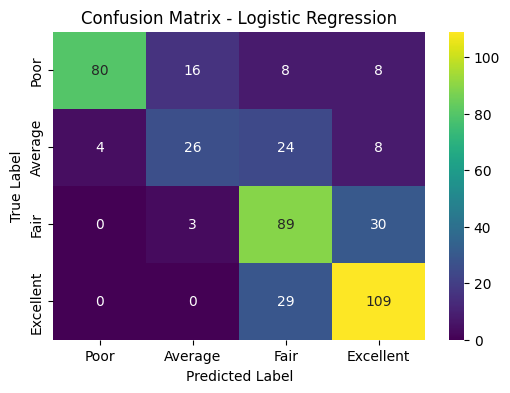

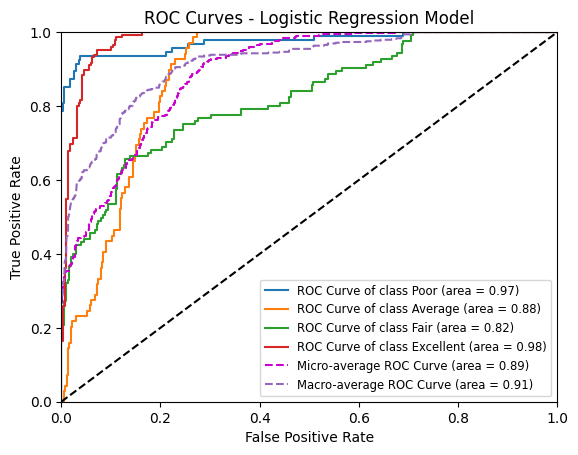

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Assuming X_train, X_test, y_train, y_test are your training and testing data
X = df_wqi.drop(columns=['WQI clf'])
y = np.ravel(df_wqi['WQI clf'])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=None)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for grid search
param_grid = {
    'C': [0.001,0.01,0.1],       # Regularization parameter
    'solver': ['lbfgs','liblinear'],  # Solver
    'max_iter': [500],
}

# Initialize Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=42)

# Grid search
grid_search = GridSearchCV(logreg_classifier, param_grid, cv=5)

# Train Logistic Regression classifier using grid search
grid_search.fit(X_train_scaled, y_train)

# Best model from grid search
best_logreg = grid_search.best_estimator_

# Predictions
y_pred_lr = best_logreg.predict(X_test_scaled)

# Assess accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_lr, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_lr, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(y_test, y_pred_lr, average='weighted')
print("F1 Score:",f1)

#CONFUSION MATRIX
# Define custom labels
custom_labels = ['Poor', 'Average', 'Fair', 'Excellent']

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix with custom labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print()

# Define a function to plot ROC curves for each class
def plot_roc_curves(y_test, y_pred_lr, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = metrics.roc_curve(y_test == i, y_pred_lr[:, i], drop_intermediate=False)
        roc_auc[class_name] = metrics.auc(fpr[class_name], tpr[class_name])
        plt.plot(fpr[class_name], tpr[class_name], label='ROC Curve of class %s (area = %0.2f)' % (class_name, roc_auc[class_name]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test, classes=[0, 1, 2, 3]).ravel(), y_pred_lr.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC Curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', color=(0.8, 0, 0.8))

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[class_name] for class_name in class_names]))
    mean_tpr = np.zeros_like(all_fpr)
    for class_name in class_names:
        mean_tpr += np.interp(all_fpr, fpr[class_name], tpr[class_name])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC Curve (area = %0.2f)' % roc_auc["macro"], linestyle='--')

    plt.title('ROC Curves - Logistic Regression Model')
    plt.legend(loc='lower right',fontsize='small')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=None)


# Assuming you have a model that predicts probability distribution for each class
model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1, fit_intercept=True,
                           intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs',
                           max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                           l1_ratio=None)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

# Plot ROC curves
class_names = ["Poor", "Average", "Fair", "Excellent"]
plot_roc_curves(y_test, y_pred, class_names)


**CATBOOST**

In [ ]:
pip install catboost

Accuracy: 0.967741935483871
Precision: 0.970961196303503
Recall: 0.967741935483871
F1 Score: 0.9675431311255368


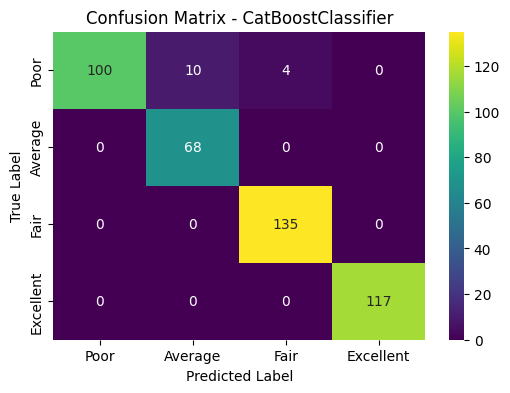

0:	learn: 1.3839574	total: 6.04ms	remaining: 54.4ms
1:	learn: 1.3814628	total: 10.5ms	remaining: 41.9ms
2:	learn: 1.3790152	total: 14.4ms	remaining: 33.6ms
3:	learn: 1.3767559	total: 18.4ms	remaining: 27.6ms
4:	learn: 1.3745973	total: 22.7ms	remaining: 22.7ms
5:	learn: 1.3722401	total: 26.7ms	remaining: 17.8ms
6:	learn: 1.3696947	total: 31.3ms	remaining: 13.4ms
7:	learn: 1.3671443	total: 39ms	remaining: 9.74ms
8:	learn: 1.3648306	total: 42.6ms	remaining: 4.74ms
9:	learn: 1.3624455	total: 46.4ms	remaining: 0us


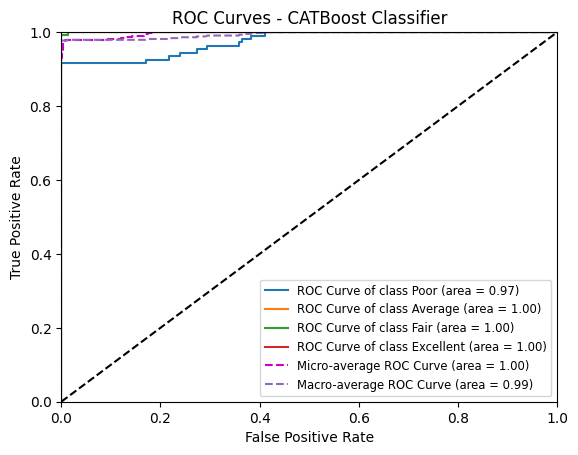

In [ ]:
from catboost import CatBoostClassifier

X= df_wqi.drop(columns=['WQI clf'])
y= np.ravel(df_wqi['WQI clf'])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=None)

# Initialize CatBoostClassifier with provided parameters
catboost_classifier = CatBoostClassifier(iterations=10, learning_rate=0.001,depth=4,loss_function='MultiClass')

# Train the model
catboost_classifier.fit(X_train, y_train, verbose=0)

# Predict on the test set
y_pred_cb = catboost_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_cb)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_cb, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_cb, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(y_test, y_pred_cb, average='weighted')
print("F1 Score:",f1)


#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

# Define custom labels
custom_labels = ['Poor', 'Average', 'Fair', 'Excellent']

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_cb)

# Plot confusion matrix with custom labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.title("Confusion Matrix - CatBoostClassifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#ROC Curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load your data (X: features, y: labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

# Define a function to plot ROC curves for each class
def plot_roc_curves(y_test, y_pred, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = metrics.roc_curve(y_test == i, y_pred[:, i], drop_intermediate=False)
        roc_auc[class_name] = metrics.auc(fpr[class_name], tpr[class_name])
        plt.plot(fpr[class_name], tpr[class_name], label='ROC Curve of class %s (area = %0.2f)' % (class_name, roc_auc[class_name]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test, classes=[0, 1, 2, 3]).ravel(), y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC Curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', color=(0.8, 0, 0.8))

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[class_name] for class_name in class_names]))
    mean_tpr = np.zeros_like(all_fpr)
    for class_name in class_names:
        mean_tpr += np.interp(all_fpr, fpr[class_name], tpr[class_name])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC Curve (area = %0.2f)' % roc_auc["macro"], linestyle='--')

    plt.title('ROC Curves - CATBoost Classifier')
    plt.legend(loc='lower right',fontsize='small')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Train your multi-class model (replace with your model)
# Assuming you have a model that predicts probability distribution for each class
model = CatBoostClassifier(iterations=10, learning_rate=0.001,depth=5,loss_function='MultiClass')
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

# Plot ROC curves
class_names = ["Poor", "Average", "Fair", "Excellent"]
plot_roc_curves(y_test, y_pred, class_names)



**RANDOM** **FOREST**

Accuracy: 0.9370277078085643
Precision: 0.9432679584782607
Recall: 0.9370277078085643
F1 Score: 0.9366110127681868


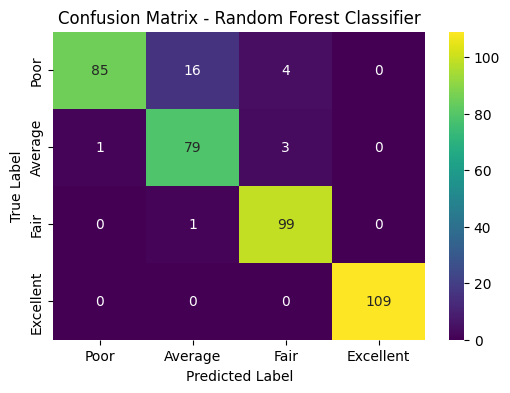

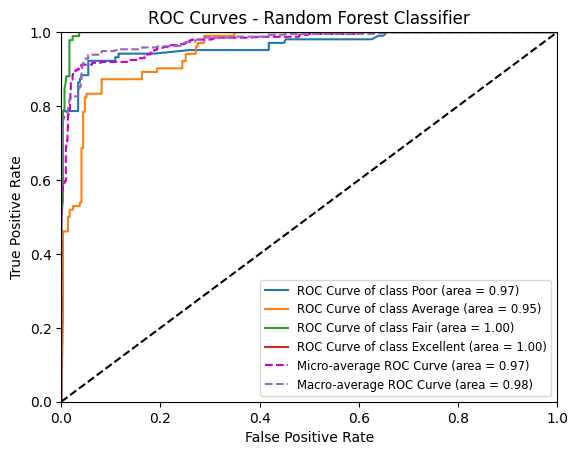

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_resampled.drop(columns=['WQI clf'])
y = np.ravel(df_resampled['WQI clf'])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=None)

# Initialize Random Forest Classifier with adjusted hyperparameters
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=2, min_samples_split=20, min_samples_leaf=20,
                                        max_features='sqrt', random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:",f1)

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

# Define custom labels
custom_labels = ['Poor', 'Average', 'Fair', 'Excellent']

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with custom labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print()


#ROC Curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load your data (X: features, y: labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

# Define a function to plot ROC curves for each class
def plot_roc_curves(y_test, y_pred, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = metrics.roc_curve(y_test == i, y_pred[:, i], drop_intermediate=False)
        roc_auc[class_name] = metrics.auc(fpr[class_name], tpr[class_name])
        plt.plot(fpr[class_name], tpr[class_name], label='ROC Curve of class %s (area = %0.2f)' % (class_name, roc_auc[class_name]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test, classes=[0, 1, 2, 3]).ravel(), y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC Curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', color=(0.8, 0, 0.8))

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[class_name] for class_name in class_names]))
    mean_tpr = np.zeros_like(all_fpr)
    for class_name in class_names:
        mean_tpr += np.interp(all_fpr, fpr[class_name], tpr[class_name])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC Curve (area = %0.2f)' % roc_auc["macro"], linestyle='--')

    plt.title('ROC Curves - Random Forest Classifier')
    plt.legend(loc='lower right',fontsize='small')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Train your multi-class model (replace with your model)
# Assuming you have a model that predicts probability distribution for each class
model = RandomForestClassifier(n_estimators=50, max_depth=2, min_samples_split=20, min_samples_leaf=20,
                                        max_features='sqrt', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

# Plot ROC curves
class_names = ["Poor", "Average", "Fair", "Excellent"]
plot_roc_curves(y_test, y_pred, class_names)
print()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_wqi.drop(columns=['WQI clf'])
y = np.ravel(df_wqi['WQI clf'])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=None)

# Initialize Random Forest Classifier with adjusted hyperparameters
rf_c = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5,
                                        max_features='auto', random_state=42)

# Train the model
rf_c.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_c.predict(X_test)


**MLP CLASSIFIER**

Accuracy: 0.8709677419354839
Precision: 0.8728551741722859
Recall: 0.8709677419354839
F1 Score: 0.8690082396465589


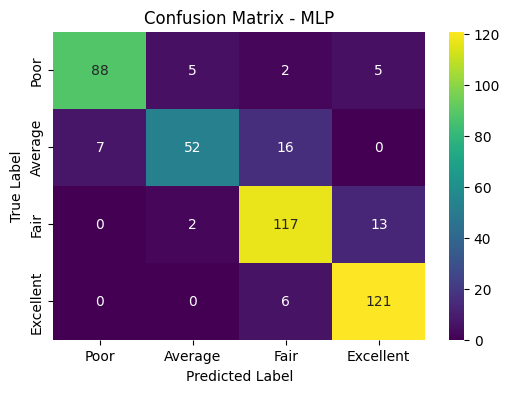

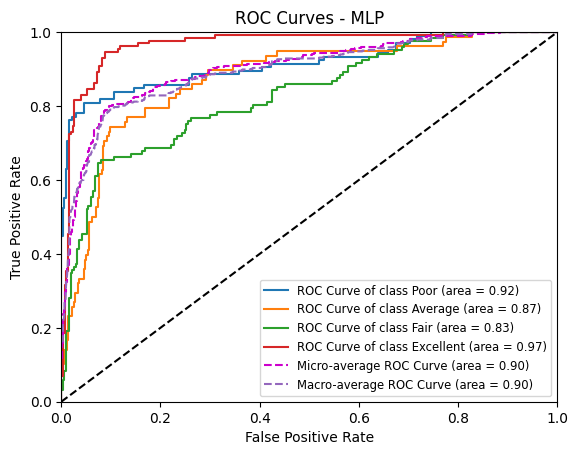

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Assuming X and y are your features and target variable respectively
X = df_wqi.drop(columns=['WQI clf'])  # Features without the target column
y = df_wqi['WQI clf']  # Target variable

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define MLPClassifier with a simplified range of hyperparameters for tuning
mlp_classifier = MLPClassifier(max_iter=1500, random_state=42, early_stopping=True)

# Define parameter grid for GridSearchCV
param_grid = {
   'hidden_layer_sizes': [(100,),(200,)],
   'alpha': [0.0001],
   'batch_size': [32]
}

# GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(mlp_classifier, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best estimator from GridSearchCV
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Train the best model on the entire training set
best_estimator.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_mlp = best_estimator.predict(X_test_scaled)

# Assess the accuracy
accuracy = best_estimator.score(X_test_scaled,y_test)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_mlp, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_mlp, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(y_test, y_pred_mlp, average='weighted')
print("F1 Score:",f1)

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

# Define custom labels
custom_labels = ['Poor', 'Average', 'Fair', 'Excellent']

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_mlp)

# Plot confusion matrix with custom labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print()

#ROC Curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load your data (X: features, y: labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

# Define a function to plot ROC curves for each class
def plot_roc_curves(y_test, y_pred, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = metrics.roc_curve(y_test == i, y_pred[:, i], drop_intermediate=False)
        roc_auc[class_name] = metrics.auc(fpr[class_name], tpr[class_name])
        plt.plot(fpr[class_name], tpr[class_name], label='ROC Curve of class %s (area = %0.2f)' % (class_name, roc_auc[class_name]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test, classes=[0, 1, 2, 3]).ravel(), y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC Curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', color=(0.8, 0, 0.8))

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[class_name] for class_name in class_names]))
    mean_tpr = np.zeros_like(all_fpr)
    for class_name in class_names:
        mean_tpr += np.interp(all_fpr, fpr[class_name], tpr[class_name])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC Curve (area = %0.2f)' % roc_auc["macro"], linestyle='--')

    plt.title('ROC Curves - MLP')
    plt.legend(loc='lower right',fontsize='small')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Train your multi-class model (replace with your model)
# Assuming you have a model that predicts probability distribution for each class
model = MLPClassifier(max_iter=1500, random_state=42, early_stopping=True)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

# Plot ROC curves
class_names = ["Poor", "Average", "Fair", "Excellent"]
plot_roc_curves(y_test, y_pred, class_names)




**DECISION TREE**

Accuracy: 0.8410138248847926
Precision: 0.8614859063873895
Recall: 0.8410138248847926
F1 Score: 0.8374434973860229


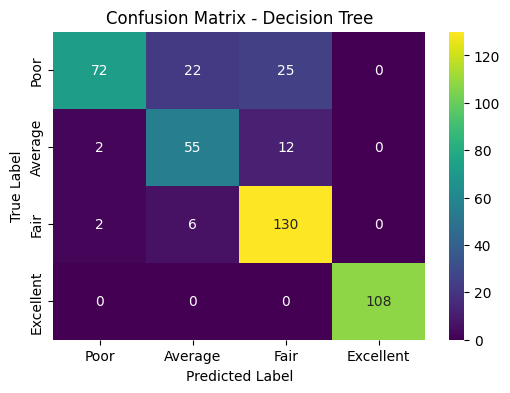

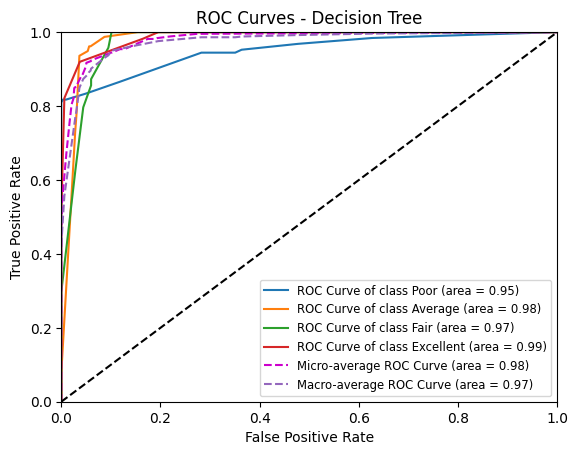

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Assuming X and y are your features and target variable respectively
X = df_wqi.drop(columns=['WQI clf'])  # Features without the target column
y = df_wqi['WQI clf']  # Target variable

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)


# Define DecisionTreeClassifier with basic parameters
decision_tree_classifier = DecisionTreeClassifier(max_depth=5, min_samples_leaf=6 ,min_samples_split=2, max_features='sqrt',class_weight='balanced')

# Train the model
decision_tree_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = decision_tree_classifier.predict(X_test)

# Assess the accuracy
accuracy = decision_tree_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_dt, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_dt, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(y_test, y_pred_dt, average='weighted')
print("F1 Score:",f1)

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

# Define custom labels
custom_labels = ['Poor', 'Average', 'Fair', 'Excellent']

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix with custom labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print()

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load your data (X: features, y: labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

# Define a function to plot ROC curves for each class
def plot_roc_curves(y_test, y_pred, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = metrics.roc_curve(y_test == i, y_pred[:, i], drop_intermediate=False)
        roc_auc[class_name] = metrics.auc(fpr[class_name], tpr[class_name])
        plt.plot(fpr[class_name], tpr[class_name], label='ROC Curve of class %s (area = %0.2f)' % (class_name, roc_auc[class_name]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test, classes=[0, 1, 2, 3]).ravel(), y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC Curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', color=(0.8, 0, 0.8))

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[class_name] for class_name in class_names]))
    mean_tpr = np.zeros_like(all_fpr)
    for class_name in class_names:
        mean_tpr += np.interp(all_fpr, fpr[class_name], tpr[class_name])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC Curve (area = %0.2f)' % roc_auc["macro"], linestyle='--')

    plt.title('ROC Curves - Decision Tree')
    plt.legend(loc='lower right',fontsize='small')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Train your multi-class model (replace with your model)
# Assuming you have a model that predicts probability distribution for each class
model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=6 ,min_samples_split=2, max_features='sqrt',class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

# Plot ROC curves
class_names = ["Poor", "Average", "Fair", "Excellent"]
plot_roc_curves(y_test, y_pred, class_names)


 **XG BOOST**

Accuracy: 0.804147465437788
Precision: 0.7032927912118927
Recall: 0.804147465437788
F1 Score: 0.739698662928309


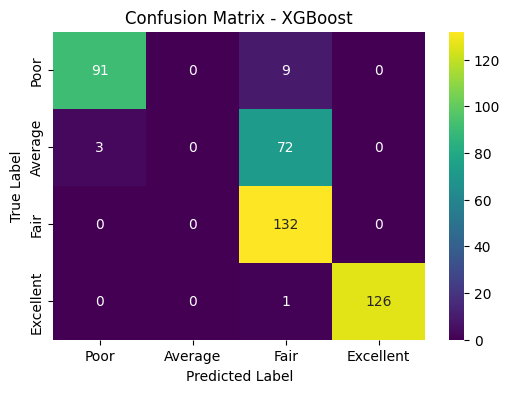

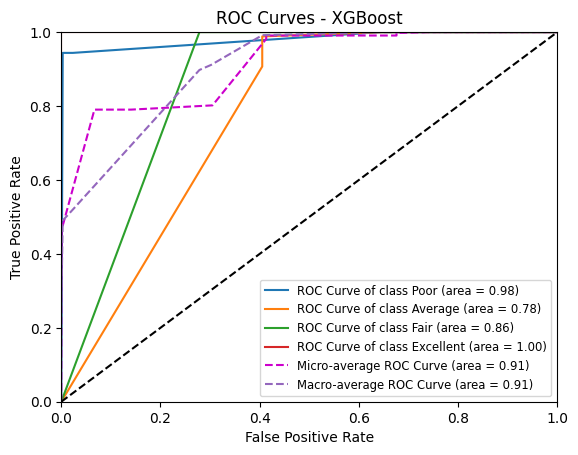

In [ ]:
from xgboost import XGBClassifier

# Assuming X and y are your features and target variable respectively
X = df_wqi.drop(columns=['WQI clf'])  # Features without the target column
y = df_wqi['WQI clf']  # Target variable

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize XGBClassifier with basic parameters
xgb_classifier = XGBClassifier(booster='gbtree',verbosity=1,validate_parameters=False,disable_default_eval_metric=False,max_depth=1,learning_rate=0.1,n_estimators=100,gamma=10,subsample=0.1,colsample_bytree=0.1,reg_alpha=10,reg_lambda=10)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_xgb, average='weighted',zero_division=0)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_xgb, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print("F1 Score:",f1)

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

# Define custom labels
custom_labels = ['Poor', 'Average', 'Fair', 'Excellent']

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix with custom labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print()

#ROC Curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load your data (X: features, y: labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

# Define a function to plot ROC curves for each class
def plot_roc_curves(y_test, y_pred, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = metrics.roc_curve(y_test == i, y_pred[:, i], drop_intermediate=False)
        roc_auc[class_name] = metrics.auc(fpr[class_name], tpr[class_name])
        plt.plot(fpr[class_name], tpr[class_name], label='ROC Curve of class %s (area = %0.2f)' % (class_name, roc_auc[class_name]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test, classes=[0, 1, 2, 3]).ravel(), y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC Curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', color=(0.8, 0, 0.8))

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[class_name] for class_name in class_names]))
    mean_tpr = np.zeros_like(all_fpr)
    for class_name in class_names:
        mean_tpr += np.interp(all_fpr, fpr[class_name], tpr[class_name])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC Curve (area = %0.2f)' % roc_auc["macro"], linestyle='--')

    plt.title('ROC Curves - XGBoost')
    plt.legend(loc='lower right',fontsize='small')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Train your multi-class model (replace with your model)
# Assuming you have a model that predicts probability distribution for each class
model =  XGBClassifier(booster='gbtree',verbosity=1,validate_parameters=False,disable_default_eval_metric=False,max_depth=1,learning_rate=0.1,n_estimators=100,gamma=10,subsample=0.1,colsample_bytree=0.1,reg_alpha=10,reg_lambda=10)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

# Plot ROC curves
class_names = ["Poor", "Average", "Fair", "Excellent"]
plot_roc_curves(y_test, y_pred, class_names)


In [ ]:
y_pred_svm = svm_model_best.predict(X_test)
y_pred_lr = best_logreg.predict(X_test_scaled)
y_pred_cb = catboost_classifier.predict(X_test)
y_pred_rf = rf_c.predict(X_test)
y_pred_mlp = best_estimator.predict(X_test_scaled)
y_pred_dt = decision_tree_classifier.predict(X_test)
y_pred_xgb = xgb_classifier.predict(X_test)

In [ ]:
for arr in (y_pred_svm, y_pred_lr,y_pred_rf,y_pred_cb, y_pred_mlp, y_pred_dt, y_pred_xgb):
    print(arr.shape)

stacking_X = np.column_stack((y_pred_svm,y_pred_lr,y_pred_cb,y_pred_rf,y_pred_mlp,y_pred_dt, y_pred_xgb))

(434,)
(434,)
(434,)
(434, 1)
(434,)
(434,)
(434,)


In [ ]:
stacking_X_train, stacking_X_test, stacking_y_train, stacking_y_test = train_test_split(stacking_X, y_test, test_size=0.35, random_state=42)


**Logistic Regression - STACK**

LOGISTIC REGRESSION
Accuracy: 0.6578947368421053
Precision: 0.5610417035855632
Recall: 0.6578947368421053
F1 Score: 0.5930968615871662


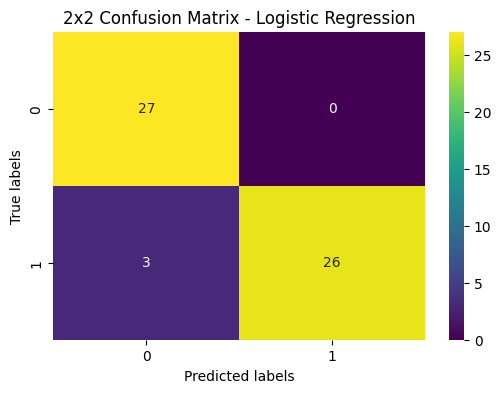

In [ ]:
# Alternatively, you can specify your chosen hyperparameters
logreg_classifier = LogisticRegression(C=0.003, solver='liblinear', max_iter=100, random_state=42)

# Train Logistic Regression classifier without grid search
logreg_classifier.fit(stacking_X_train, stacking_y_train)

# Predictions
y_pred_stack_lr = logreg_classifier.predict(stacking_X_test)

print("LOGISTIC REGRESSION")

#Calculate accuracy
accuracy = accuracy_score(stacking_y_test, y_pred_stack_lr)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(stacking_y_test,y_pred_stack_lr, average='weighted',zero_division=0)
print("Precision:", precision)

# Calculate recall
recall = recall_score(stacking_y_test,y_pred_stack_lr, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(stacking_y_test,y_pred_stack_lr, average='weighted')
print("F1 Score:",f1)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(stacking_y_test, y_pred_stack_lr)

# Aggregate counts for classes 0 and 1 as negative class, and classes 2 and 3 as positive class
TN = conf_matrix[0, 0] + conf_matrix[0, 1]  # True negatives
FP = conf_matrix[1, 0] + conf_matrix[1, 1]  # False positives
FN = conf_matrix[0, 2] + conf_matrix[0, 3]  # False negatives
TP = conf_matrix[1, 2] + conf_matrix[1, 3]  # True positives

# Create a 2x2 confusion matrix
binary_conf_matrix = np.array([[TN, FP],
                               [FN, TP]])

# Plot the 2x2 confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(binary_conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('2x2 Confusion Matrix - Logistic Regression')
plt.show()


**SVM - STACK**

In [ ]:
# Initialize SVM classifier with specified hyperparameters
svm_classifier = SVC(C=0.025, kernel='rbf',degree=3,gamma='scale', random_state=42)

# Train SVM classifier
svm_classifier.fit(stacking_X_train, stacking_y_train)

# Make predictions on the test data
y_pred_stack_svm = svm_classifier.predict(stacking_X_test)

print("SVM")

# Calculate accuracy
accuracy_svm = accuracy_score(stacking_y_test, y_pred_stack_svm)
print("Accuracy:", accuracy_svm)

# Calculate precision
precision_svm = precision_score(stacking_y_test, y_pred_stack_svm, average='weighted', zero_division=0)
print("Precision:", precision_svm)

# Calculate recall
recall_svm = recall_score(stacking_y_test, y_pred_stack_svm, average='weighted')
print("Recall:", recall_svm)

# Calculate f1-score
f1_svm = f1_score(stacking_y_test, y_pred_stack_svm, average='weighted')
print("F1 Score:", f1_svm)


SVM
Accuracy: 0.7960526315789473
Precision: 0.7060560053981106
Recall: 0.7960526315789473
F1 Score: 0.7352772948705703


**CATBOOST - STACK**

In [ ]:
# Initialize CatBoostClassifier with provided parameters
catboost_classifier_s = CatBoostClassifier(iterations=1000,learning_rate=0.01,depth=10,loss_function='MultiClass',random_state=42)

# Train the model
catboost_classifier_s.fit(stacking_X_train,stacking_y_train, verbose=0)

# Predict on the test set
y_pred_stack_cb = catboost_classifier_s.predict(stacking_X_test)

print("CATBOOST")

# Calculate accuracy
accuracy = accuracy_score(stacking_y_test, y_pred_stack_cb)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(stacking_y_test, y_pred_stack_cb, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(stacking_y_test, y_pred_stack_cb, average='weighted')
print("Recall:", recall)

#Calculate f-score
f1 = f1_score(stacking_y_test, y_pred_stack_cb, average='weighted')
print("F1 Score:",f1)


CATBOOST
Accuracy: 0.9868421052631579
Precision: 0.9868421052631579
Recall: 0.9868421052631579
F1 Score: 0.9868421052631579


**RANDOM FOREST - STACK**

In [ ]:
# Instantiate Random Forest classifier with chosen hyperparameters
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_split=2, min_samples_leaf=5,
                                        max_features='sqrt', random_state=42)

# Train Random Forest classifier
rf_classifier.fit(stacking_X_train, stacking_y_train)

# Make predictions
y_pred_stack_rf = rf_classifier.predict(stacking_X_test)

print("RANDOMFOREST")

# Calculate accuracy
accuracy = accuracy_score(stacking_y_test, y_pred_stack_rf)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(stacking_y_test, y_pred_stack_rf, average='weighted', zero_division=0)
print("Precision:", precision)

# Calculate recall
recall = recall_score(stacking_y_test, y_pred_stack_rf, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(stacking_y_test, y_pred_stack_rf, average='weighted')
print("F1 Score:", f1)


RANDOMFOREST
Accuracy: 0.9868421052631579
Precision: 0.9873791621911922
Recall: 0.9868421052631579
F1 Score: 0.9867523064125832


**MLP - STACK**

In [ ]:
# Instantiate MLP classifier with chosen hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                                alpha=0.0001, batch_size='auto', learning_rate='constant',
                                learning_rate_init=0.001, max_iter=1000, shuffle=False,
                                random_state=42, tol=0.0001)

# Train MLP classifier
mlp_classifier.fit(stacking_X_train, stacking_y_train)

# Make predictions
y_pred_stack_mlp = mlp_classifier.predict(stacking_X_test)

print("MLP")

# Calculate accuracy
accuracy = accuracy_score(stacking_y_test, y_pred_stack_mlp)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(stacking_y_test, y_pred_stack_mlp, average='weighted', zero_division=0)
print("Precision:", precision)

# Calculate recall
recall = recall_score(stacking_y_test, y_pred_stack_mlp, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(stacking_y_test, y_pred_stack_mlp, average='weighted')
print("F1 Score:", f1)


MLP
Accuracy: 0.9868421052631579
Precision: 0.9868421052631579
Recall: 0.9868421052631579
F1 Score: 0.9868421052631579


**Decision Tree - STACK**

In [ ]:
# Instantiate Decision Tree classifier with chosen hyperparameters
dt_classifier = DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=5,
                                       max_features=None, random_state=42)

# Train Decision Tree classifier
dt_classifier.fit(stacking_X_train, stacking_y_train)

# Make predictions
y_pred_stack_dt = dt_classifier.predict(stacking_X_test)

print("DECISON TREE")

# Calculate accuracy
accuracy = accuracy_score(stacking_y_test, y_pred_stack_dt)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(stacking_y_test, y_pred_stack_dt, average='weighted', zero_division=0)
print("Precision:", precision)

# Calculate recall
recall = recall_score(stacking_y_test, y_pred_stack_dt, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(stacking_y_test, y_pred_stack_dt, average='weighted')
print("F1 Score:", f1)


DECISON TREE
Accuracy: 0.9868421052631579
Precision: 0.9873791621911922
Recall: 0.9868421052631579
F1 Score: 0.9867523064125832


In [ ]:
# Instantiate XGBoost classifier with adjusted hyperparameters
xgb_classifier_s = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100,
                               min_child_weight=1, gamma=0, subsample=1,
                               colsample_bytree=1, reg_alpha=0, reg_lambda=1,
                               random_state=42)

# Train XGBoost classifier
xgb_classifier_s.fit(stacking_X_train, stacking_y_train)

# Make predictions
y_pred_stack_xgb = xgb_classifier_s.predict(stacking_X_test)

print("XG BOOST")

# Calculate accuracy
accuracy = accuracy_score(stacking_y_test, y_pred_stack_xgb)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(stacking_y_test, y_pred_stack_xgb, average='weighted', zero_division=0)
print("Precision:", precision)

# Calculate recall
recall = recall_score(stacking_y_test, y_pred_stack_xgb, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(stacking_y_test, y_pred_stack_xgb, average='weighted')
print("F1 Score:", f1)



XG BOOST
Accuracy: 0.9868421052631579
Precision: 0.9868421052631579
Recall: 0.9868421052631579
F1 Score: 0.9868421052631579
